# Understanding and modeling climate impacts on photosynthetic dynamics with FLUXNET data and neural networks
Nanyan "Rosalie" Zhu and Chen "Raphael" Liu

### Import packages.

In [1]:
import numpy as np
import pandas as pd
import os
import sys
from matplotlib import pyplot as plt
import seaborn as sns
import math
from scipy.stats import pearsonr
import random

import torch
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib

import warnings
warnings.filterwarnings('ignore')

E:\anaconda3\envs\RR\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


### Add a visualization tool into system path.

In [2]:
sys.path.append(os.path.abspath('../pytorch-summary'))

In [3]:
from torchsummary import summary

### Check GPU availability

In [4]:
cuda = torch.cuda.is_available()
print("GPU available:", cuda)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

GPU available: True


### Set the random seed for reproducibility.
The random seed helps to make sure that the model parameter initialization, sequence of random shuffling, and most other nondeterministic operations are kept the same each time you run this notebook.

In [5]:
torch.manual_seed(2020)
np.random.seed(2020)

### Load the dataset.

In [22]:
dataset_folder = './dataset/'

forest1_csv = pd.read_csv(dataset_folder + 'FLX_NL-Loo_DD_1996-2014.csv')
forest1_csv_relevant = forest1_csv[['GPP', 'FSDS', 'Prcp', 'T', 'FLDS', 'VPD']]
forest1_csv_relevant_clean = forest1_csv_relevant.dropna()
forest1_csv_relevant_clean.columns = ['GPP', 'Solar Rad', 'Precipitation', 'Temperature', 'Longwave Rad', 'VPD']
factors_forest1, GPP_forest1 = forest1_csv_relevant_clean[['GPP', 'Solar Rad', 'Precipitation', 'Temperature', 'Longwave Rad', 'VPD']].values, forest1_csv_relevant_clean['GPP'].values

forest2_csv = pd.read_csv(dataset_folder + 'FLX_DE-Tha_DD_1996-2014.csv')
forest2_csv_relevant = forest2_csv[['GPP', 'FSDS', 'Prcp', 'T', 'FLDS', 'VPD']]
forest2_csv_relevant_clean = forest2_csv_relevant.dropna()
forest2_csv_relevant_clean.columns = ['GPP', 'Solar Rad', 'Precipitation', 'Temperature', 'Longwave Rad', 'VPD']
factors_forest2, GPP_forest2 = forest2_csv_relevant_clean[['GPP', 'Solar Rad', 'Precipitation', 'Temperature', 'Longwave Rad', 'VPD']].values, forest2_csv_relevant_clean['GPP'].values


grassland1_csv = pd.read_csv(dataset_folder + 'FLX_AT-Neu_DD_2002-2012.csv')
grassland1_csv_relevant = grassland1_csv[['GPP', 'FSDS', 'Prcp', 'T', 'FLDS', 'VPD']]
grassland1_csv_relevant_clean = grassland1_csv_relevant.dropna()
grassland1_csv_relevant_clean.columns = ['GPP', 'Solar Rad', 'Precipitation', 'Temperature', 'Longwave Rad', 'VPD']
factors_grassland1, GPP_grassland1 = grassland1_csv_relevant_clean[['GPP', 'Solar Rad', 'Precipitation', 'Temperature', 'Longwave Rad', 'VPD']].values, grassland1_csv_relevant_clean['GPP'].values

grassland2_csv = pd.read_csv(dataset_folder + 'FLX_US-Var_DD_2000-2014.csv')
grassland2_csv_relevant = grassland2_csv[['GPP', 'FSDS', 'Prcp', 'T', 'FLDS', 'VPD']]
grassland2_csv_relevant_clean = grassland2_csv_relevant.dropna()
grassland2_csv_relevant_clean.columns = ['GPP', 'Solar Rad', 'Precipitation', 'Temperature', 'Longwave Rad', 'VPD']
factors_grassland2, GPP_grassland2 = grassland2_csv_relevant_clean[['GPP', 'Solar Rad', 'Precipitation', 'Temperature', 'Longwave Rad', 'VPD']].values, grassland2_csv_relevant_clean['GPP'].values

print('Forest 1 (Loo) temperature mean %.1f, std %.1f (degree C)' %(np.mean(forest1_csv_relevant_clean['Temperature'].values), np.std(forest1_csv_relevant_clean['Temperature'].values)))
print('Forest 2 (Tha) temperature mean %.1f, std %.1f (degree C)' %(np.mean(forest2_csv_relevant_clean['Temperature'].values), np.std(forest2_csv_relevant_clean['Temperature'].values)))
print('Grassland 1 (Neu) temperature mean %.1f, std %.1f (degree C)' %(np.mean(grassland1_csv_relevant_clean['Temperature'].values), np.std(grassland1_csv_relevant_clean['Temperature'].values)))
print('Grassland 2 (Var) temperature mean %.1f, std %.1f (degree C)\n' %(np.mean(grassland2_csv_relevant_clean['Temperature'].values), np.std(grassland2_csv_relevant_clean['Temperature'].values)))

print('Forest 1 (Loo) annual precipitation mean %.1f, std %.1f (mm/yr)' %(np.mean(forest1_csv_relevant_clean['Precipitation'].values) * 24 * 365.25, np.std(forest1_csv_relevant_clean['Precipitation'].values) * 24 * 365.25))
print('Forest 2 (Tha) annual precipitation mean %.1f, std %.1f (mm/yr)' %(np.mean(forest2_csv_relevant_clean['Precipitation'].values) * 24 * 365.25, np.std(forest2_csv_relevant_clean['Precipitation'].values) * 24 * 365.25))
print('Grassland 1 (Neu) annual precipitation mean %.1f, std %.1f (mm/yr)' %(np.mean(grassland1_csv_relevant_clean['Precipitation'].values) * 24 * 365.25, np.std(grassland1_csv_relevant_clean['Precipitation'].values) * 24 * 365.25))
print('Grassland 2 (Var) annual precipitation mean %.1f, std %.1f (mm/yr)\n' %(np.mean(grassland2_csv_relevant_clean['Precipitation'].values) * 24 * 365.25, np.std(grassland2_csv_relevant_clean['Precipitation'].values) * 24 * 365.25))

print('Forest 1 (Loo) GPP mean %.1f, std %.1f (gC/m^2/day)' %(np.mean(forest1_csv_relevant_clean['GPP'].values), np.std(forest1_csv_relevant_clean['GPP'].values)))
print('Forest 2 (Tha) GPP mean %.1f, std %.1f (gC/m^2/day)' %(np.mean(forest2_csv_relevant_clean['GPP'].values), np.std(forest2_csv_relevant_clean['GPP'].values)))
print('Grassland 1 (Neu) GPP mean %.1f, std %.1f (gC/m^2/day)' %(np.mean(grassland1_csv_relevant_clean['GPP'].values), np.std(grassland1_csv_relevant_clean['GPP'].values)))
print('Grassland 2 (Var) GPP mean %.1f, std %.1f (gC/m^2/day)' %(np.mean(grassland2_csv_relevant_clean['GPP'].values), np.std(grassland2_csv_relevant_clean['GPP'].values)))

Forest 1 (Loo) temperature mean 10.1, std 6.4 (degree C)
Forest 2 (Tha) temperature mean 8.8, std 7.9 (degree C)
Grassland 1 (Neu) temperature mean 6.8, std 8.2 (degree C)
Grassland 2 (Var) temperature mean 15.8, std 6.8 (degree C)

Forest 1 (Loo) annual precipitation mean 419.8, std 828.2 (mm/yr)
Forest 2 (Tha) annual precipitation mean 421.0, std 988.9 (mm/yr)
Grassland 1 (Neu) annual precipitation mean 334.3, std 814.8 (mm/yr)
Grassland 2 (Var) annual precipitation mean 282.4, std 981.1 (mm/yr)

Forest 1 (Loo) GPP mean 4.3, std 3.1 (gC/m^2/day)
Forest 2 (Tha) GPP mean 5.1, std 4.1 (gC/m^2/day)
Grassland 1 (Neu) GPP mean 5.9, std 5.9 (gC/m^2/day)
Grassland 2 (Var) GPP mean 1.8, std 2.8 (gC/m^2/day)


### Data visualization.

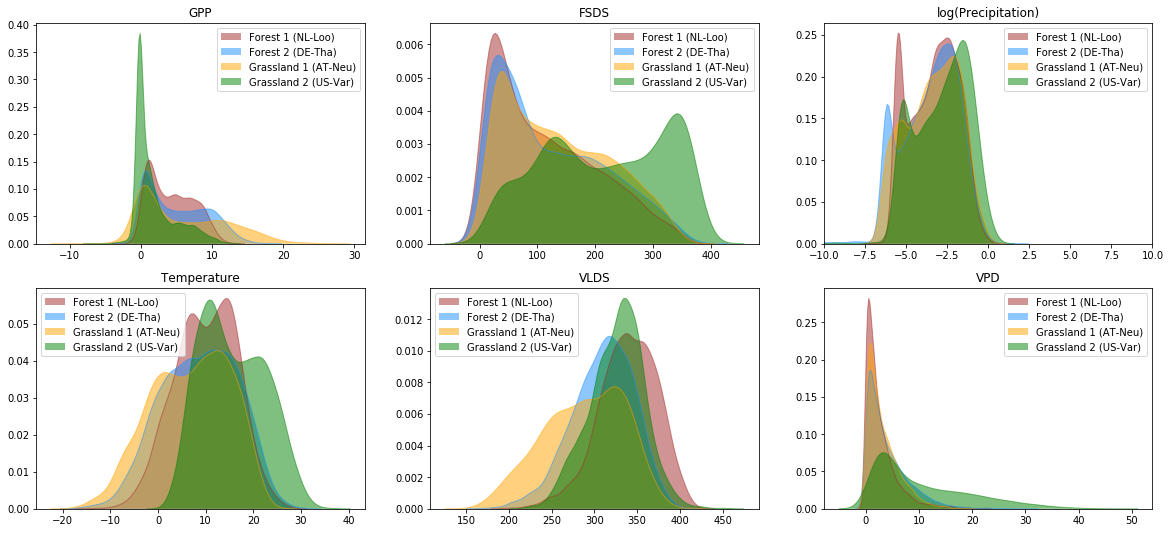

In [7]:
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(top = 0.8, wspace = 0.2, hspace = 0.2)
for variable_index in range(forest1_csv_relevant_clean.shape[1]):
    ax = fig.add_subplot(2, 3, variable_index + 1)
    if variable_index == 2:
        sns.kdeplot(np.log(forest1_csv_relevant_clean.iloc[:, variable_index].values), color = 'brown', shade = True, linewidth = 1, alpha = 0.5)
        sns.kdeplot(np.log(forest2_csv_relevant_clean.iloc[:, variable_index].values), color = 'dodgerblue', shade = True, linewidth = 1, alpha = 0.5)
        sns.kdeplot(np.log(grassland1_csv_relevant_clean.iloc[:, variable_index].values), color = 'orange', shade = True, linewidth = 1,  alpha = 0.5)
        sns.kdeplot(np.log(grassland2_csv_relevant_clean.iloc[:, variable_index].values), color = 'green', shade = True, linewidth = 1, alpha = 0.5)
        plt.xlim([-10, 10])
    else:
        sns.kdeplot(forest1_csv_relevant_clean.iloc[:, variable_index].values, color = 'brown', shade = True, linewidth = 1, alpha = 0.5)
        sns.kdeplot(forest2_csv_relevant_clean.iloc[:, variable_index].values, color = 'dodgerblue', shade = True, linewidth = 1, alpha = 0.5)
        sns.kdeplot(grassland1_csv_relevant_clean.iloc[:, variable_index].values, color = 'orange', shade = True, linewidth = 1,  alpha = 0.5)
        sns.kdeplot(grassland2_csv_relevant_clean.iloc[:, variable_index].values, color = 'green', shade = True, linewidth = 1, alpha = 0.5)
    
    plt.legend(['Forest 1 (NL-Loo)', 'Forest 2 (DE-Tha)', 'Grassland 1 (AT-Neu)', 'Grassland 2 (US-Var)'])
    if variable_index == 0:
        plt.title('GPP')
    elif variable_index == 1:
        plt.title('FSDS')
    elif variable_index == 2:
        plt.title('log(Precipitation)')
    elif variable_index == 3:
        plt.title('Temperature')
    elif variable_index == 4:
        plt.title('VLDS')
    elif variable_index == 5:
        plt.title('VPD')
    else:
        print('You probably made a mistake if you end up here.')

#sns.pairplot(forest1_csv_relevant_clean)
#sns.pairplot(forest2_csv_relevant_clean)
#sns.pairplot(grassland1_csv_relevant_clean)
#sns.pairplot(grassland2_csv_relevant_clean);

### Define helper functions to handle the dataset.

In [8]:
def normalize_data(raw_data, scaling_file = None):
    '''
    Scale the dataset to range 0 to 1 and write the scaling factors to a file.
    This is necessary because the neural networks are better off when dealing with 
    normalized values. After the opeartions is done by the neural networks, we can
    access the scaling file and scale the output values back to the original data range.
    '''
    scaler = MinMaxScaler(feature_range = (0, 1))
    data_scaled = scaler.fit_transform(raw_data)
    if not scaling_file is None:
        joblib.dump(scaler, scaling_file)
    return data_scaled

def inverse_normalize_data(data_scaled, scaling_file):
    '''
    Inverse-scale the normalized data back the original data range.
    '''    
    scaler = joblib.load(scaling_file)
    backscaled_data = scaler.inverse_transform(data_scaled)

    return backscaled_data

## TASK ONE
### 1) Predict the GPP at the current time point, given the environmental factors at the current time point.
### 2) Leave-one-out study on the 6 environmental factors.

### Candidate 1: Feedforward Neural Network (FFNN).

In [23]:
class FFNN(torch.nn.Module):
    def __init__(self, input_channel = 6, output_channel = 1):
        super(FFNN, self).__init__()
        self.input_channel = input_channel
        self.output_channel = output_channel

        self.fc1 = torch.nn.Linear(self.input_channel, 10)
        self.fc2 = torch.nn.Linear(10, 20)
        self.fc3 = torch.nn.Linear(20, 20)
        self.fc4 = torch.nn.Linear(20, 10)
        self.fc5 = torch.nn.Linear(10, self.output_channel)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)

        return x

In [85]:
def loss_function(prediction, label):
    return (label - prediction) ** 2

def predict_single_timepoint_with_FFNN(x, y, train_ratio = 0.8, test_ratio = 0.1, \
                                  input_duration = 1, prediction_delay = 1, num_epoch = 20, \
                                       track_loss_history = False, report_test_loss = True):
    '''
    Please note that we assume the y to be a 1D vector, hence the reshape(-1, 1).
    '''

    # Scale the time series input data and output ground truth.
    x = normalize_data(x)
    y = normalize_data(y.reshape(-1, 1), 'y_scaling_factor')

    # Use the beginning of the time series data to train the model.
    # Meanwhile, we need to convert the data to a 3D tensor of dimension (k, t, n),
    # meaning that we have k sets of time series with duration t and channel number n.
    x_train = []
    y_train = []
    for timepoint in range(input_duration, int(len(x) * train_ratio) - prediction_delay):
        x_train.append(x[timepoint - input_duration : timepoint, :])
        y_train.append(y[timepoint + prediction_delay, :].reshape(-1, 1))
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Use the second portion for validation.
    x_validation = []
    y_validation = []
    for timepoint in range(int(len(x) * train_ratio) - input_duration, int(len(x) * (1 - test_ratio)) - prediction_delay):
        x_validation.append(x[timepoint - input_duration : timepoint, :])
        y_validation.append(y[timepoint + prediction_delay, :].reshape(-1, 1))
    x_validation, y_validation = np.array(x_validation), np.array(y_validation)
    
    # Use the last portion for testing.
    x_test = []
    y_test = []
    for timepoint in range(int(len(x) * (1 - test_ratio)) - input_duration, int(len(x)) - prediction_delay):
        x_test.append(x[timepoint - input_duration : timepoint, :])
        y_test.append(y[timepoint + prediction_delay, :].reshape(-1, 1))        
    x_test, y_test = np.array(x_test), np.array(y_test)
    
    # Define the input and output channels of the FFNN cell.
    try:
        assert x_train.shape[2] == x_validation.shape[2] and x_train.shape[2] == x_test.shape[2]
        assert y_train.shape[2] == y_validation.shape[2] and y_train.shape[2] == y_test.shape[2]
    except:
        print('Channel dimension mismatch. train, validation, and test set should share the same channel dimension.')

    input_channel = x_train.shape[2]
    output_channel = y_train.shape[2]
    
    our_model = FFNN(input_channel = input_channel, output_channel = output_channel).to(device)

    optimizer = optim.SGD(our_model.parameters(), lr = 0.002, momentum = 0.5)
    
    # Learning rate scheduler.
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience = 2, verbose = True)
    
    validation_loss_history = []
    print('Start training...')
    for epoch in range(num_epoch):
        ######################################### Train ##########################################
        our_model.train()
        # Create a list to store the losses over every epoch.
        Epoch_train_loss_list = []
        # Random shuffle.
        shuffled_indices = np.arange(len(x_train))
        random.shuffle(shuffled_indices)
        shuffled_x_train = x_train[shuffled_indices, :, :]
        shuffled_y_train = y_train[shuffled_indices, :, :]
        # Pack up the training data.
        training_data = zip(shuffled_x_train, shuffled_y_train)
        # enumerate the training data.
        for iteration, training_input_GT_pair in enumerate(training_data):
            # isolate the training input and ground truth from the training data.
            our_input, our_GT = iter(training_input_GT_pair)
            # redefine the training input and ground truth and PyTorch tensors.
            our_input, our_GT = Variable(torch.FloatTensor(our_input)).to(device), \
                                 Variable(torch.FloatTensor(our_GT)).to(device)

            # reset the gradient for the optimizer.
            optimizer.zero_grad()
            # use the current model to predict the output from the input.
            our_prediction = our_model(our_input)
            
            # compute the loss (metric of goodness) between the prediction and the ground truth.
            train_loss = loss_function(our_prediction, our_GT)
            # backpropogate the gradient
            train_loss.backward()
            # update the weights using the gradient with the optimizer
            optimizer.step()

            # append the current loss value to the loss list for this epoch.
            Epoch_train_loss_list.append(train_loss.cpu().data.item())

            # print the current loss every 1000 iterations.
            if track_loss_history:
                if (iteration % 1e3 == 0):
                    print("[Train] Epoch {} - train loss: {}".format(epoch, np.mean(Epoch_train_loss_list)))
        
        ######################################### Validation ########################################
        our_model.eval()
        Epoch_validation_loss_list = []
        validation_data = zip(x_validation, y_validation)
        for iteration, validation_input_GT_pair in enumerate(validation_data):
            our_input, our_GT = iter(validation_input_GT_pair)
            our_input, our_GT = Variable(torch.FloatTensor(our_input)).to(device), \
                                 Variable(torch.FloatTensor(our_GT)).to(device)
            our_prediction = our_model(our_input)
            validation_loss = loss_function(our_prediction, our_GT)
            Epoch_validation_loss_list.append(validation_loss.cpu().data.item())
        if track_loss_history:
            print("[Validation] Epoch {} - validation loss: {}".format(epoch, np.mean(Epoch_validation_loss_list)))
        validation_loss_history.append(np.mean(Epoch_validation_loss_list))
        
        # Reduce LR On Plateau
        scheduler.step(np.mean(Epoch_validation_loss_list))
        
        # Stop training when the validation loss increases.
        #if len(validation_loss_history) > 1:
        #    if validation_loss_history[-1] > validation_loss_history[-2]:
        #        if track_loss_history:
        #            print('Validation loss stop decreasing. Stop training.')
        #        break
        #    else:
        #        # save models
        #        os.makedirs('./saved_models', exist_ok = True)
        #        torch.save(our_model.state_dict(), './saved_models/best_model.pth')
        if np.mean(Epoch_validation_loss_list) == np.min(validation_loss_history):
            # save models
            os.makedirs('./saved_models', exist_ok = True)
            torch.save(our_model.state_dict(), './saved_models/best_model.pth')

    ############################################ Test #############################################
    our_model.eval()
    state_dict = torch.load('./saved_models/best_model.pth')
    our_model.load_state_dict(state_dict)

    test_loss_list = []
    y_prediction = []
    test_data = zip(x_test, y_test)
    for iteration, test_input_GT_pair in enumerate(test_data):
        our_input, our_GT = iter(test_input_GT_pair)
        our_input, our_GT = Variable(torch.FloatTensor(our_input)).to(device), \
                             Variable(torch.FloatTensor(our_GT)).to(device)
        our_prediction = our_model(our_input)
        y_prediction.append(our_prediction)
        test_loss = loss_function(our_prediction, our_GT)
        test_loss_list.append(test_loss.data.cpu().data.item())
    if report_test_loss:
        print("[Test] Test loss: {}".format(np.mean(test_loss_list)))
    
    y_prediction = np.array(torch.cat(y_prediction, axis = -1).cpu().detach()).reshape(-1, 1)

    # Transform the prediction and ground truth to the original scaling.
    y_prediction = inverse_normalize_data(y_prediction.reshape(-1, 1), 'y_scaling_factor')
    y_test = inverse_normalize_data(y_test.reshape(-1, 1), 'y_scaling_factor')
    
    if report_test_loss:
        print("[Test] Correlation {}".format(pearsonr(y_prediction.reshape(-1).astype('float32'), y_test.reshape(-1).astype('float32'))[0]))
    
    return y_prediction.reshape(-1), y_test.reshape(-1)

### Candidate 2. Long Short-Term Memory (LSTM).
Code for setting up the LSTM module is directly copied from [Jessica Yung's page](https://www.jessicayung.com/lstms-for-time-series-in-pytorch/).

In [191]:
class LSTM(torch.nn.Module):

    def __init__(self, input_feature_dimension, hidden_dimension = 20, batch_size = 1, num_layers = 1):
        super(LSTM, self).__init__()
        self.input_feature_dimension = input_feature_dimension
        self.hidden_dimension = hidden_dimension
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = torch.nn.LSTM(self.input_feature_dimension, self.hidden_dimension, self.num_layers)
        self.hidden = self.init_hidden

        # Define the output layer
        self.linear = torch.nn.Linear(self.hidden_dimension, 1)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dimension),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dimension))

    def forward(self, lstm_input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dimension]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dimension).
        lstm_output, self.hidden = self.lstm(lstm_input.view(len(lstm_input), self.batch_size, -1))

        # Only take the output from the final timestep
        # Can pass on the entirety of lstm_output to the next layer if it is a seq2seq prediction
        y_prediction = self.linear(lstm_output[-1].view(self.batch_size, -1))
        return y_prediction.view(1, -1)

In [204]:
loss_function = torch.nn.MSELoss(size_average = False)

def predict_time_series_with_LSTM(x, y, train_ratio = 0.8, test_ratio = 0.1, \
                                  input_duration = 30, prediction_delay = 1, num_epoch = 20, \
                                       track_loss_history = False, report_test_loss = True):
    '''
    Please note that we assume the y to be a 1D vector, hence the reshape(-1, 1).
    '''
    
    # Scale the time series input data and output ground truth.
    x = normalize_data(x)
    y = normalize_data(y.reshape(-1, 1), 'y_scaling_factor')

    # Use the beginning of the time series data to train the model.
    # Meanwhile, we need to convert the data to a 3D tensor of dimension (k, t, n),
    # meaning that we have k sets of time series with duration t and channel number n.
    x_train = []
    y_train = []
    for timepoint in range(input_duration, int(len(x) * train_ratio) - prediction_delay):
        x_train.append(x[timepoint - input_duration : timepoint, :])
        y_train.append(y[timepoint + prediction_delay, :].reshape(-1, 1))
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Use the second portion for validation.
    x_validation = []
    y_validation = []
    for timepoint in range(int(len(x) * train_ratio) - input_duration, int(len(x) * (1 - test_ratio)) - prediction_delay):
        x_validation.append(x[timepoint - input_duration : timepoint, :])
        y_validation.append(y[timepoint + prediction_delay, :].reshape(-1, 1))
    x_validation, y_validation = np.array(x_validation), np.array(y_validation)
    
    # Use the last portion for testing.
    x_test = []
    y_test = []
    for timepoint in range(int(len(x) * (1 - test_ratio)) - input_duration, int(len(x)) - prediction_delay):
        x_test.append(x[timepoint - input_duration : timepoint, :])
        y_test.append(y[timepoint + prediction_delay, :].reshape(-1, 1))        
    x_test, y_test = np.array(x_test), np.array(y_test)
    
    # Define the input and output channels of the LSTM cell.
    try:
        assert x_train.shape[2] == x_validation.shape[2] and x_train.shape[2] == x_test.shape[2]
        assert y_train.shape[2] == y_validation.shape[2] and y_train.shape[2] == y_test.shape[2]
    except:
        print('Channel dimension mismatch. train, validation, and test set should share the same channel dimension.')

    input_channel = x_train.shape[2]
    
    our_model = LSTM(input_feature_dimension = input_channel).to(device)

    optimizer = optim.SGD(our_model.parameters(), lr = 0.002, momentum = 0.5)
    
    # Learning rate scheduler.
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience = 2, verbose = True)
    
    validation_loss_history = []
    print('Start training...')
    for epoch in range(num_epoch):
        ######################################### Train ##########################################
        our_model.train()
        # Create a list to store the losses over every epoch.
        Epoch_train_loss_list = []
        # Random shuffle.
        shuffled_indices = np.arange(len(x_train))
        random.shuffle(shuffled_indices)
        shuffled_x_train = x_train[shuffled_indices, :, :]
        shuffled_y_train = y_train[shuffled_indices, :, :]
        # Pack up the training data.
        training_data = zip(shuffled_x_train, shuffled_y_train)
        # enumerate the training data.
        for iteration, training_input_GT_pair in enumerate(training_data):
            # isolate the training input and ground truth from the training data.
            our_input, our_GT = iter(training_input_GT_pair)
            # redefine the training input and ground truth and PyTorch tensors.
            our_input, our_GT = Variable(torch.FloatTensor(our_input)).to(device), \
                                 Variable(torch.FloatTensor(our_GT)).to(device)

            # reset the gradient for the optimizer.
            optimizer.zero_grad()
            # use the current model to predict the output from the input.
            our_prediction = our_model(our_input)
            # compute the loss (metric of goodness) between the prediction and the ground truth.
            train_loss = loss_function(our_prediction, our_GT)
            # backpropogate the gradient
            train_loss.backward()
            # update the weights using the gradient with the optimizer
            optimizer.step()

            # append the current loss value to the loss list for this epoch.
            Epoch_train_loss_list.append(train_loss.cpu().data.item())

            # print the current loss every 1000 iterations.
            if track_loss_history:
                if (iteration % 1e3 == 0):
                    print("[Train] Epoch {} - train loss: {}".format(epoch, np.mean(Epoch_train_loss_list)))
        
        ######################################### Validation ########################################
        our_model.eval()
        Epoch_validation_loss_list = []
        validation_data = zip(x_validation, y_validation)
        for iteration, validation_input_GT_pair in enumerate(validation_data):
            our_input, our_GT = iter(validation_input_GT_pair)
            our_input, our_GT = Variable(torch.FloatTensor(our_input)).to(device), \
                                 Variable(torch.FloatTensor(our_GT)).to(device)
            our_prediction = our_model(our_input)
            validation_loss = loss_function(our_prediction, our_GT)
            Epoch_validation_loss_list.append(validation_loss.cpu().data.item())
        if track_loss_history:
            print("[Validation] Epoch {} - validation loss: {}".format(epoch, np.mean(Epoch_validation_loss_list)))
        validation_loss_history.append(np.mean(Epoch_validation_loss_list))
        
        # Reduce LR On Plateau
        scheduler.step(np.mean(Epoch_validation_loss_list))
        
        # Stop training when the validation loss increases.
        #if len(validation_loss_history) > 1:
        #    if validation_loss_history[-1] > validation_loss_history[-2]:
        #        if track_loss_history:
        #            print('Validation loss stop decreasing. Stop training.')
        #        break
        #    else:
        #        # save models
        #        os.makedirs('./saved_models', exist_ok = True)
        #        torch.save(our_model.state_dict(), './saved_models/best_model.pth')
        if np.mean(Epoch_validation_loss_list) == np.min(validation_loss_history):
            # save models
            os.makedirs('./saved_models', exist_ok = True)
            torch.save(our_model.state_dict(), './saved_models/best_model.pth')

    ############################################ Test #############################################
    our_model.eval()
    state_dict = torch.load('./saved_models/best_model.pth')
    our_model.load_state_dict(state_dict)

    test_loss_list = []
    y_prediction = []
    test_data = zip(x_test, y_test)
    for iteration, test_input_GT_pair in enumerate(test_data):
        our_input, our_GT = iter(test_input_GT_pair)
        our_input, our_GT = Variable(torch.FloatTensor(our_input)).to(device), \
                             Variable(torch.FloatTensor(our_GT)).to(device)
        our_prediction = our_model(our_input)
        y_prediction.append(our_prediction)
        test_loss = loss_function(our_prediction, our_GT)
        test_loss_list.append(test_loss.data.cpu().data.item())
    if report_test_loss:
        print("[Test] Test loss: {}".format(np.mean(test_loss_list)))
    
    y_prediction = np.array(torch.cat(y_prediction, axis = -1).cpu().detach()).reshape(-1, 1)
    
    # Transform the prediction and ground truth to the original scaling.
    y_prediction = inverse_normalize_data(y_prediction.reshape(-1, 1), 'y_scaling_factor')
    y_test = inverse_normalize_data(y_test.reshape(-1, 1), 'y_scaling_factor')
     
    if report_test_loss:
        print("[Test] Correlation {}".format(pearsonr(y_prediction.reshape(-1).astype('float32'), y_test.reshape(-1).astype('float32'))[0]))
    
    return y_prediction.reshape(-1), y_test.reshape(-1)

### Candidate 3. Transformer.

In [266]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import pdb

class TransformerModel(nn.Module):

    def __init__(self, inp_mem, ninp, nhead, nhid, nlayers, dropout = 0.2):
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.ninp = ninp
        self.decoder_layer1 = nn.Linear(ninp * inp_mem, 1)

        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.decoder_layer1.bias.data.zero_()
        self.decoder_layer1.weight.data.uniform_(-initrange, initrange)
        #self.decoder_layer2.bias.data.zero_()
        #self.decoder_layer2.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = output.view(-1)
        output = self.decoder_layer1(output)
        #output = output.view(-1)
        #output = self.decoder_layer2(output)
        return output

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        #pdb.set_trace()
        pe[:, 0::2] = torch.sin(position * div_term)
        if pe.shape[1] % 2 == 0:
            pe[:, 1::2] = torch.cos(position * div_term)
        else:
            pe[:, 1::2] = torch.cos(position * div_term)[:, :-1]
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [267]:
loss_function = torch.nn.MSELoss(size_average = False)

def predict_time_series_with_transformer(x, y, train_ratio = 0.8, test_ratio = 0.1, \
                                  input_duration = 30, prediction_delay = 1, num_epoch = 30, \
                                       track_loss_history = False, report_test_loss = True):
    '''
    Please note that we assume the y to be a 1D vector, hence the reshape(-1, 1).
    '''
    torch.manual_seed(2020)
    np.random.seed(2020)
    # Scale the time series input data and output ground truth.
    x = normalize_data(x)
    y = normalize_data(y.reshape(-1, 1), 'y_scaling_factor')

    # Use the beginning of the time series data to train the model.
    # Meanwhile, we need to convert the data to a 3D tensor of dimension (k, t, n),
    # meaning that we have k sets of time series with duration t and channel number n.
    x_train = []
    y_train = []
    for timepoint in range(input_duration, int(len(x) * train_ratio) - prediction_delay):
        x_train.append(x[timepoint - input_duration : timepoint, :])
        y_train.append(y[timepoint + prediction_delay, :].reshape(-1, 1))
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Use the second portion for validation.
    x_validation = []
    y_validation = []
    for timepoint in range(int(len(x) * train_ratio) - input_duration, int(len(x) * (1 - test_ratio)) - prediction_delay):
        x_validation.append(x[timepoint - input_duration : timepoint, :])
        y_validation.append(y[timepoint + prediction_delay, :].reshape(-1, 1))
    x_validation, y_validation = np.array(x_validation), np.array(y_validation)
    
    # Use the last portion for testing.
    x_test = []
    y_test = []
    for timepoint in range(int(len(x) * (1 - test_ratio)) - input_duration, int(len(x)) - prediction_delay):
        x_test.append(x[timepoint - input_duration : timepoint, :])
        y_test.append(y[timepoint + prediction_delay, :].reshape(-1, 1))        
    x_test, y_test = np.array(x_test), np.array(y_test)
   
    # Define the input and output channels of the transformer cell.
    try:
        assert x_train.shape[2] == x_validation.shape[2] and x_train.shape[2] == x_test.shape[2]
        assert y_train.shape[2] == y_validation.shape[2] and y_train.shape[2] == y_test.shape[2]
    except:
        print('Channel dimension mismatch. train, validation, and test set should share the same channel dimension.')

    input_channel = x_train.shape[2]
    output_channel = y_train.shape[2]
   
    source_vocab = len(x)
    target_vocab = len(y)
    our_model = TransformerModel(ninp = input_channel, inp_mem = input_duration, nhead = 1, nhid = 50, nlayers = 2).to(device)

    optimizer = optim.SGD(our_model.parameters(), lr = 0.005, momentum = 0.5)
   
    # Learning rate scheduler.
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience = 2, verbose = True)
   
    validation_loss_history = []
    print('Start training...')
    for epoch in range(num_epoch):
        ######################################### Train ##########################################
        our_model.train()
        # Create a list to store the losses over every epoch.
        Epoch_train_loss_list = []
        # Random shuffle.
        shuffled_indices = np.arange(len(x_train))
        random.shuffle(shuffled_indices)
        shuffled_x_train = x_train[shuffled_indices, :, :]
        shuffled_y_train = y_train[shuffled_indices, :, :]
        # Pack up the training data.
        training_data = zip(shuffled_x_train, shuffled_y_train)
        # enumerate the training data.
        for iteration, training_input_GT_pair in enumerate(training_data):
            # isolate the training input and ground truth from the training data.
            our_input, our_GT = iter(training_input_GT_pair)
            # redefine the training input and ground truth and PyTorch tensors.
            our_input, our_GT = Variable(torch.FloatTensor(our_input)).to(device), \
                                 Variable(torch.FloatTensor(our_GT)).to(device)
            ######### MODIFICATION ##########
            our_input = our_input[np.newaxis, :, :]
            our_GT = our_GT[np.newaxis, :, :]
            #################################
            #pdb.set_trace()
            #print('input: ', our_input)
            #print('GT: ', our_GT)
            # reset the gradient for the optimizer.
            optimizer.zero_grad()
            # use the current model to predict the output from the input.
            #pdb.set_trace()
            our_prediction = our_model(our_input)
           
            # compute the loss (metric of goodness) between the prediction and the ground truth.
            train_loss = loss_function(our_prediction, our_GT)
            
            #print('prediction: ', our_prediction.shape)
            #print('loss: ', train_loss)
            
            # backpropogate the gradient
            train_loss.backward()
            
            # clip gradient
            """
            total_norm = 0
            for p in our_model.parameters():
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
            print(total_norm ** (1. / 2))
            """
            #torch.nn.utils.clip_grad_norm_(our_model.parameters(), 0.5)
            
            # update the weights using the gradient with the optimizer
            optimizer.step()

            # append the current loss value to the loss list for this epoch.
            Epoch_train_loss_list.append(train_loss.cpu().data.item())

            # print the current loss every 1000 iterations.
            if track_loss_history:
                if (iteration % 1e3 == 0):
                    print("[Train] Epoch {} - train loss: {}".format(epoch, np.mean(Epoch_train_loss_list)))
       
        ######################################### Validation ########################################
        our_model.eval()
        Epoch_validation_loss_list = []
        validation_data = zip(x_validation, y_validation)
        for iteration, validation_input_GT_pair in enumerate(validation_data):
            our_input, our_GT = iter(validation_input_GT_pair)
            our_input, our_GT = Variable(torch.FloatTensor(our_input)).to(device), \
                                 Variable(torch.FloatTensor(our_GT)).to(device)
            # reshape the input size
            our_input = our_input[np.newaxis, :, :]
            our_GT = our_GT[np.newaxis, :, :]
            
            our_prediction = our_model(our_input)
            validation_loss = loss_function(our_prediction, our_GT)
            Epoch_validation_loss_list.append(validation_loss.cpu().data.item())
        if track_loss_history:
            print("[Validation] Epoch {} - validation loss: {}".format(epoch, np.mean(Epoch_validation_loss_list)))
        validation_loss_history.append(np.mean(Epoch_validation_loss_list))
       
        # Reduce LR On Plateau
        scheduler.step(np.mean(Epoch_validation_loss_list))
       
        # Stop training when the validation loss increases.
        #if len(validation_loss_history) > 1:
        #    if validation_loss_history[-1] > validation_loss_history[-2]:
        #        if track_loss_history:
        #            print('Validation loss stop decreasing. Stop training.')
        #        break
        #    else:
        #        # save models
        #        os.makedirs('./saved_models', exist_ok = True)
        #        torch.save(our_model.state_dict(), './saved_models/best_model.pth')
        if np.mean(Epoch_validation_loss_list) == np.min(validation_loss_history):
            # save models
            os.makedirs('./saved_models', exist_ok = True)
            torch.save(our_model.state_dict(), './saved_models/Transformer_best_model.pth')

    ############################################ Test #############################################
    our_model.eval()
    state_dict = torch.load('./saved_models/Transformer_best_model.pth')
    our_model.load_state_dict(state_dict)

    test_loss_list = []
    y_prediction = []
    test_data = zip(x_test, y_test)
    for iteration, test_input_GT_pair in enumerate(test_data):
        our_input, our_GT = iter(test_input_GT_pair)
        our_input, our_GT = Variable(torch.FloatTensor(our_input)).to(device), \
                             Variable(torch.FloatTensor(our_GT)).to(device)
        
        # reshape the input size
        our_input = our_input[np.newaxis, :, :]
        our_GT = our_GT[np.newaxis, :, :]
        
        our_prediction = our_model(our_input)
        y_prediction.append(our_prediction)
        test_loss = loss_function(our_prediction, our_GT)
        test_loss_list.append(test_loss.data.cpu().data.item())
    if report_test_loss:
        print("[Test] Test loss: {}".format(np.mean(test_loss_list)))
   
    y_prediction = np.array(torch.cat(y_prediction, axis = -1).cpu().detach()).reshape(-1, 1)

    # Transform the prediction and ground truth to the original scaling.
    y_prediction = inverse_normalize_data(y_prediction.reshape(-1, 1), 'y_scaling_factor')
    y_test = inverse_normalize_data(y_test.reshape(-1, 1), 'y_scaling_factor')
   
    if report_test_loss:
        print("[Test] Correlation {}".format(pearsonr(y_prediction.reshape(-1).astype('float32'), y_test.reshape(-1).astype('float32'))[0]))
   
    return y_prediction.reshape(-1), y_test.reshape(-1)

### Perform TASK ONE.
### Use candidate 1: FFNN.

In [101]:
for site in ['forest1', 'forest2', 'grassland1', 'grassland2']:
    locals()['GPP_' + site + '_prediction_FFNN_all'] = []
    locals()['GPP_' + site + '_test_FFNN_all'] = []

for site in ['forest1', 'forest2', 'grassland1', 'grassland2']:
    locals()['GPP_' + site + '_prediction_FFNN'], locals()['GPP_' + site + '_test_FFNN'] = \
    predict_single_timepoint_with_FFNN(locals()['factors_' + site], locals()['GPP_' + site])
    locals()['GPP_' + site + '_prediction_FFNN_all'].append(locals()['GPP_' + site + '_prediction_FFNN'])
    locals()['GPP_' + site + '_test_FFNN_all'].append(locals()['GPP_' + site + '_test_FFNN'])
    
for leave_one_out_index in range(locals()['factors_' + site].shape[1] + 1):
    for site in ['forest1', 'forest2', 'grassland1', 'grassland2']:
        locals()['GPP_' + site + '_prediction_FFNN_leave_out_factor_' + str(leave_one_out_index)], \
        locals()['GPP_' + site + '_test_FFNN_leave_out_factor_' + str(leave_one_out_index)] = \
        predict_single_timepoint_with_FFNN(np.delete(locals()['factors_' + site], leave_one_out_index - 1, axis = 1), \
                                           locals()['GPP_' + site])
        
        locals()['GPP_' + site + '_prediction_FFNN_all'].append(locals()['GPP_' + site + '_prediction_FFNN_leave_out_factor_' + str(leave_one_out_index)])
        locals()['GPP_' + site + '_test_FFNN_all'].append(locals()['GPP_' + site + '_test_FFNN_leave_out_factor_' + str(leave_one_out_index)])

Start training...
Epoch    14: reducing learning rate of group 0 to 1.6000e-03.
Epoch    17: reducing learning rate of group 0 to 1.2800e-03.
Epoch    20: reducing learning rate of group 0 to 1.0240e-03.
[Test] Test loss: 0.009521699974694155
[Test] Correlation 0.8707442940528185
Start training...
Epoch    14: reducing learning rate of group 0 to 1.6000e-03.
Epoch    17: reducing learning rate of group 0 to 1.2800e-03.
[Test] Test loss: 0.00792922644928894
[Test] Correlation 0.9197392956017327
Start training...
Epoch    14: reducing learning rate of group 0 to 1.6000e-03.
Epoch    17: reducing learning rate of group 0 to 1.2800e-03.
Epoch    20: reducing learning rate of group 0 to 1.0240e-03.
[Test] Test loss: 0.0029350322210050916
[Test] Correlation 0.9407326633450654
Start training...
Epoch    15: reducing learning rate of group 0 to 1.6000e-03.
Epoch    18: reducing learning rate of group 0 to 1.2800e-03.
[Test] Test loss: 0.0020210009151919346
[Test] Correlation 0.9480152518448237

In [103]:
np.savez('FLUXNET_GPP_FFNN.npz', FFNN_y_test1_all = GPP_forest1_test_FFNN_all, FFNN_y_pred1_all = GPP_forest1_prediction_FFNN_all,
                                FFNN_y_test2_all = GPP_forest2_test_FFNN_all, FFNN_y_pred2_all = GPP_forest2_prediction_FFNN_all,
                                FFNN_y_test3_all = GPP_grassland1_test_FFNN_all, FFNN_y_pred3_all = GPP_grassland1_prediction_FFNN_all,
                                FFNN_y_test4_all = GPP_grassland2_test_FFNN_all, FFNN_y_pred4_all = GPP_grassland2_prediction_FFNN_all)

### Use candidate 2: LSTM.

In [58]:
for site in ['forest1', 'forest2', 'grassland1', 'grassland2']:
    locals()['GPP_' + site + '_prediction_LSTM_all'] = []
    locals()['GPP_' + site + '_test_LSTM_all'] = []

for site in ['forest1', 'forest2', 'grassland1', 'grassland2']:
    locals()['GPP_' + site + '_prediction_LSTM'], locals()['GPP_' + site + '_test_LSTM'] = \
    predict_time_series_with_LSTM(locals()['factors_' + site], locals()['GPP_' + site])
    locals()['GPP_' + site + '_prediction_LSTM_all'].append(locals()['GPP_' + site + '_prediction_LSTM'])
    locals()['GPP_' + site + '_test_LSTM_all'].append(locals()['GPP_' + site + '_test_LSTM'])

for leave_one_out_index in range(locals()['factors_' + site].shape[1] + 1):
    for site in ['forest1', 'forest2', 'grassland1', 'grassland2']:
        locals()['GPP_' + site + '_prediction_LSTM_leave_out_factor_' + str(leave_one_out_index)], \
        locals()['GPP_' + site + '_test_LSTM_leave_out_factor_' + str(leave_one_out_index)] = \
        predict_time_series_with_LSTM(np.delete(locals()['factors_' + site], leave_one_out_index - 1, axis = 1), \
                                             locals()['GPP_' + site])

        locals()['GPP_' + site + '_prediction_LSTM_all'].append(locals()['GPP_' + site + '_prediction_LSTM_leave_out_factor_' + str(leave_one_out_index)])
        locals()['GPP_' + site + '_test_LSTM_all'].append(locals()['GPP_' + site + '_test_LSTM_leave_out_factor_' + str(leave_one_out_index)])

Start training...
Epoch    10: reducing learning rate of group 0 to 1.6000e-03.
Epoch    15: reducing learning rate of group 0 to 1.2800e-03.
Epoch    18: reducing learning rate of group 0 to 1.0240e-03.
[Test] Test loss: 0.007638719426140391
[Test] Correlation 0.8993698700025593
Start training...
Epoch    13: reducing learning rate of group 0 to 1.6000e-03.
[Test] Test loss: 0.007170975534128934
[Test] Correlation 0.9291885454400053
Start training...
[Test] Test loss: 0.0028675368643166755
[Test] Correlation 0.9389361155909215
Start training...
[Test] Test loss: 0.0015187267213509045
[Test] Correlation 0.9596819611818305
Start training...
[Test] Test loss: 0.007616548024328842
[Test] Correlation 0.8994101578495317
Start training...
Epoch    18: reducing learning rate of group 0 to 1.6000e-03.
[Test] Test loss: 0.007332804457057328
[Test] Correlation 0.9276304004814064
Start training...
[Test] Test loss: 0.002884770911524018
[Test] Correlation 0.9383561641950576
Start training...
[Test

In [59]:
np.savez('FLUXNET_GPP_LSTM.npz', LSTM_y_test1_all = GPP_forest1_test_LSTM_all, LSTM_y_pred1_all = GPP_forest1_prediction_LSTM_all,
                                LSTM_y_test2_all = GPP_forest2_test_LSTM_all, LSTM_y_pred2_all = GPP_forest2_prediction_LSTM_all,
                                LSTM_y_test3_all = GPP_grassland1_test_LSTM_all, LSTM_y_pred3_all = GPP_grassland1_prediction_LSTM_all,
                                LSTM_y_test4_all = GPP_grassland2_test_LSTM_all, LSTM_y_pred4_all = GPP_grassland2_prediction_LSTM_all)

### Use Candidate 3: Transformer

In [268]:
for site in ['forest1', 'forest2', 'grassland1', 'grassland2']:
    locals()['GPP_' + site + '_prediction_Transformer_all'] = []
    locals()['GPP_' + site + '_test_Transformer_all'] = []

for site in ['forest1', 'forest2', 'grassland1', 'grassland2']:
    locals()['GPP_' + site + '_prediction_Transformer'], locals()['GPP_' + site + '_test_Transformer'] = \
    predict_time_series_with_transformer(locals()['factors_' + site], locals()['GPP_' + site])
    locals()['GPP_' + site + '_prediction_Transformer_all'].append(locals()['GPP_' + site + '_prediction_Transformer'])
    locals()['GPP_' + site + '_test_Transformer_all'].append(locals()['GPP_' + site + '_test_Transformer'])

for leave_one_out_index in range(locals()['factors_' + site].shape[1] + 1):
    for site in ['forest1', 'forest2', 'grassland1', 'grassland2']:
        locals()['GPP_' + site + '_prediction_Transformer_leave_out_factor_' + str(leave_one_out_index)], \
        locals()['GPP_' + site + '_test_Transformer_leave_out_factor_' + str(leave_one_out_index)] = \
        predict_time_series_with_transformer(np.delete(locals()['factors_' + site], leave_one_out_index - 1, axis = 1), \
                                             locals()['GPP_' + site])

        locals()['GPP_' + site + '_prediction_Transformer_all'].append(locals()['GPP_' + site + '_prediction_Transformer_leave_out_factor_' + str(leave_one_out_index)])
        locals()['GPP_' + site + '_test_Transformer_all'].append(locals()['GPP_' + site + '_test_Transformer_leave_out_factor_' + str(leave_one_out_index)])

Start training...
Epoch    10: reducing learning rate of group 0 to 2.5000e-03.
Epoch    13: reducing learning rate of group 0 to 1.2500e-03.
Epoch    16: reducing learning rate of group 0 to 6.2500e-04.
Epoch    19: reducing learning rate of group 0 to 3.1250e-04.
Epoch    22: reducing learning rate of group 0 to 1.5625e-04.
Epoch    25: reducing learning rate of group 0 to 7.8125e-05.
Epoch    28: reducing learning rate of group 0 to 3.9063e-05.
[Test] Test loss: 0.008930373080489941
[Test] Correlation 0.8823130338174034
Start training...
Epoch     4: reducing learning rate of group 0 to 2.5000e-03.
Epoch    10: reducing learning rate of group 0 to 1.2500e-03.
Epoch    13: reducing learning rate of group 0 to 6.2500e-04.
Epoch    18: reducing learning rate of group 0 to 3.1250e-04.
Epoch    21: reducing learning rate of group 0 to 1.5625e-04.
Epoch    24: reducing learning rate of group 0 to 7.8125e-05.
Epoch    27: reducing learning rate of group 0 to 3.9063e-05.
Epoch    30: reduci

In [31]:
np.savez('FLUXNET_GPP_Transformer.npz', Transformer_y_test1_all = GPP_forest1_test_Transformer_all, Transformer_y_pred1_all = GPP_forest1_prediction_Transformer_all,
                                Transformer_y_test2_all = GPP_forest2_test_Transformer_all, Transformer_y_pred2_all = GPP_forest2_prediction_Transformer_all,
                                Transformer_y_test3_all = GPP_grassland1_test_Transformer_all, Transformer_y_pred3_all = GPP_grassland1_prediction_Transformer_all,
                                Transformer_y_test4_all = GPP_grassland2_test_Transformer_all, Transformer_y_pred4_all = GPP_grassland2_prediction_Transformer_all)

In [258]:
def plot_mse_correlation(model_name, variants = 7, task = 1, ylim1 = None, ylim2 = None):
    
    data = np.load('FLUXNET_GPP_%s.npz' % model_name, allow_pickle = True)
    y_test1_all = data['%s_y_test1_all' % model_name]
    y_pred1_all = data['%s_y_pred1_all' % model_name]
    y_test2_all = data['%s_y_test2_all' % model_name]
    y_pred2_all = data['%s_y_pred2_all' % model_name]
    y_test3_all = data['%s_y_test3_all' % model_name]
    y_pred3_all = data['%s_y_pred3_all' % model_name]
    y_test4_all = data['%s_y_test4_all' % model_name]
    y_pred4_all = data['%s_y_pred4_all' % model_name]

    mse_1 = np.full([variants], np.nan)
    mse_2 = np.full([variants], np.nan)
    mse_3 = np.full([variants], np.nan)
    mse_4 = np.full([variants], np.nan)

    for i in range(variants):
        mse_1[i] = np.nanmean((y_test1_all[i] - y_pred1_all[i]) ** 2)
        mse_2[i] = np.nanmean((y_test2_all[i] - y_pred2_all[i]) ** 2)
        mse_3[i] = np.nanmean((y_test3_all[i] - y_pred3_all[i]) ** 2)
        mse_4[i] = np.nanmean((y_test4_all[i] - y_pred4_all[i]) ** 2)

    correlation_1 = np.full([variants], np.nan)
    correlation_2 = np.full([variants], np.nan)
    correlation_3 = np.full([variants], np.nan)
    correlation_4 = np.full([variants], np.nan)

    for i in range(variants):
        [correlation_1[i], pvalue] = pearsonr(y_test1_all[i].flatten(), y_pred1_all[i].flatten())
        [correlation_2[i], pvalue] = pearsonr(y_test2_all[i].flatten(), y_pred2_all[i].flatten())
        [correlation_3[i], pvalue] = pearsonr(y_test3_all[i].flatten(), y_pred3_all[i].flatten())
        [correlation_4[i], pvalue] = pearsonr(y_test4_all[i].flatten(), y_pred4_all[i].flatten())

    fig, ax = plt.subplots(1, 2, figsize = (15, 4))

    ind = np.arange(variants)
    p1 = ax[0].bar(ind, mse_1, width = 0.2, color = 'brown')
    p2 = ax[0].bar(ind + 0.2, mse_2, width = 0.2, color = 'dodgerblue')
    p3 = ax[0].bar(ind + 0.4, mse_3, width = 0.2, color = 'orange')
    p4 = ax[0].bar(ind + 0.6, mse_4, width = 0.2, color = 'green')
    ax[0].set_title('Mean Square Error')
    ax[0].set_xticks(ind + 0.3)
    if task == 1:
        ax[0].set_xticklabels(('all', 'no GPP', 'no FSDS', 'no Pre', 'no Temp', 'no FLDS', 'no VPD'))
    else:
        ax[0].set_xticklabels(('1 day', '1 week', '2 weeks', '3 weeks', '4 weeks'))
    ax[0].legend((p1[0], p2[0], p3[0], p4[0]), ('Forest 1 (NL-Loo)', 'Forest 2 (DE-Tha)', 'Grassland 1 (AT-Neu)', 'Grassland 2 (US-Var)'))
    if not ylim1 is None:
        ax[0].set_ylim(bottom = ylim1[0], top = ylim1[1])    
    
    p1 = ax[1].bar(ind, correlation_1, width = 0.2,color = 'brown')
    p2 = ax[1].bar(ind + 0.2, correlation_2, width = 0.2, color = 'dodgerblue')
    p3 = ax[1].bar(ind + 0.4, correlation_3, width = 0.2, color = 'orange')
    p4 = ax[1].bar(ind + 0.6, correlation_4, width = 0.2, color = 'green')

    ax[1].set_title('Pearson Correlation Coefficient')
    ax[1].set_xticks(ind + 0.3)
    if task == 1:
        ax[1].set_xticklabels(('all', 'no GPP', 'no FSDS', 'no Pre', 'no Temp', 'no FLDS', 'no VPD'))
    else:
        ax[1].set_xticklabels(('1 day', '1 week', '2 weeks', '3 weeks', '4 weeks'))
    if not ylim2 is None:
        ax[1].set_ylim(bottom = ylim2[0], top = ylim2[1])
    plt.savefig('FLUXNET_GPP_FFNN_prediction.png', dpi = 600)

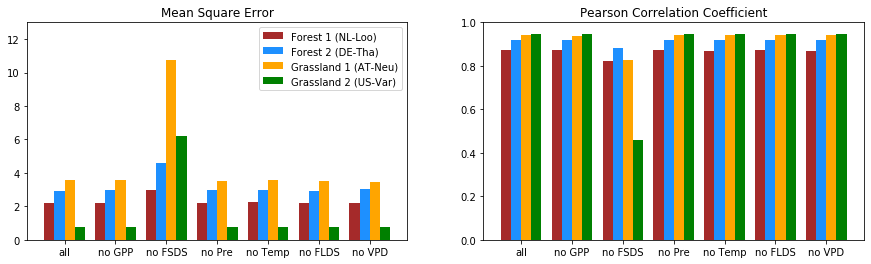

In [259]:
plot_mse_correlation('FFNN', ylim1 = [0, 13], ylim2 = [0, 1])

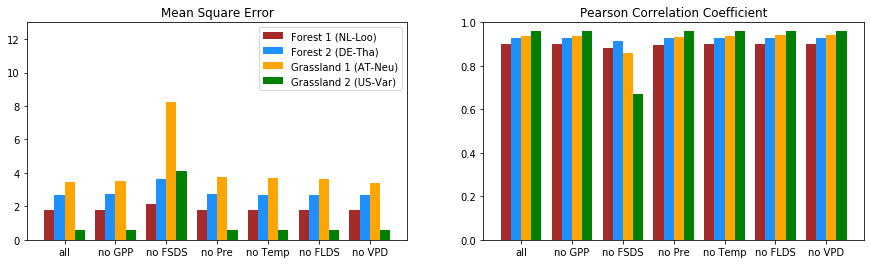

In [260]:
plot_mse_correlation('LSTM', ylim1 = [0, 13], ylim2 = [0, 1])

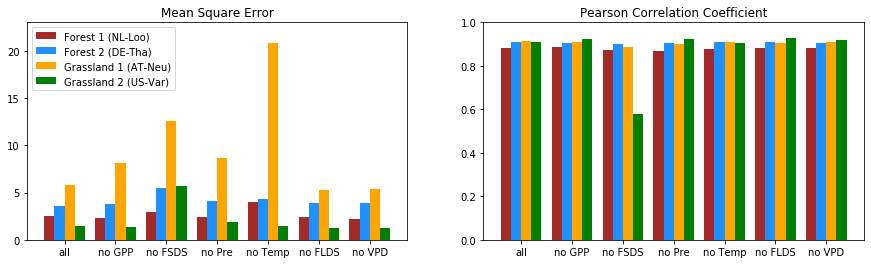

In [261]:
plot_mse_correlation('Transformer', ylim1 = [0, 23], ylim2 = [0, 1])

## Task 2. Model the temporal dependency of GPP with LSTM.

In [113]:
for site in ['forest1', 'forest2', 'grassland1', 'grassland2']:
    locals()['various_input_duration_GPP_' + site + '_prediction_LSTM_all'] = []
    locals()['various_input_duration_GPP_' + site + '_test_LSTM_all'] = []

for input_duration in [1, 7, 14, 21, 28]:
    for site in ['forest1', 'forest2', 'grassland1', 'grassland2']:
        locals()['input_duration_%s_GPP_' % str(input_duration).zfill(2) + site + '_prediction_LSTM'], \
        locals()['input_duration_%s_GPP_' % str(input_duration).zfill(2) + site + '_test_LSTM'] = \
        predict_time_series_with_LSTM(locals()['factors_' + site], locals()['GPP_' + site], input_duration = input_duration)
        locals()['various_input_duration_GPP_' + site + '_prediction_LSTM_all'].append(locals()['input_duration_%s_GPP_' % str(input_duration).zfill(2) + site + '_prediction_LSTM'])
        locals()['various_input_duration_GPP_' + site + '_test_LSTM_all'].append(locals()['input_duration_%s_GPP_' % str(input_duration).zfill(2) + site + '_test_LSTM'])

Start training...
[Test] Test loss: 0.0096292501737685
[Test] Correlation 0.8692519194462168
Start training...
[Test] Test loss: 0.00791053326776795
[Test] Correlation 0.9200160061675073
Start training...
[Test] Test loss: 0.0039049910171313398
[Test] Correlation 0.9205158798329729
Start training...
[Test] Test loss: 0.002108121366439243
[Test] Correlation 0.9458291669988379
Start training...
[Test] Test loss: 0.007875162539015424
[Test] Correlation 0.8945802058025787
Start training...
[Test] Test loss: 0.007581056270125312
[Test] Correlation 0.924144749362048
Start training...
[Test] Test loss: 0.002782745481114992
[Test] Correlation 0.9430385038891869
Start training...
[Test] Test loss: 0.0014835439937844362
[Test] Correlation 0.9619505872290968
Start training...
Epoch    20: reducing learning rate of group 0 to 1.6000e-03.
[Test] Test loss: 0.007763912324092315
[Test] Correlation 0.8967149546899469
Start training...
Epoch    16: reducing learning rate of group 0 to 1.6000e-03.
[Test

In [118]:
np.savez('FLUXNET_GPP_LSTM_various_input_duration.npz',
         LSTM_various_input_duration_y_test1_all = various_input_duration_GPP_forest1_test_LSTM_all, LSTM_various_input_duration_y_pred1_all = various_input_duration_GPP_forest1_prediction_LSTM_all,
         LSTM_various_input_duration_y_test2_all = various_input_duration_GPP_forest2_test_LSTM_all, LSTM_various_input_duration_y_pred2_all = various_input_duration_GPP_forest2_prediction_LSTM_all,
         LSTM_various_input_duration_y_test3_all = various_input_duration_GPP_grassland1_test_LSTM_all, LSTM_various_input_duration_y_pred3_all = various_input_duration_GPP_grassland1_prediction_LSTM_all,
         LSTM_various_input_duration_y_test4_all = various_input_duration_GPP_grassland2_test_LSTM_all, LSTM_various_input_duration_y_pred4_all = various_input_duration_GPP_grassland2_prediction_LSTM_all)

In [209]:
for site in ['forest1', 'forest2', 'grassland1', 'grassland2']:
    locals()['various_prediction_delay_GPP_' + site + '_prediction_LSTM_all'] = []
    locals()['various_prediction_delay_GPP_' + site + '_test_LSTM_all'] = []

for prediction_delay in [1, 7, 14, 21, 28]:
    for site in ['forest1', 'forest2', 'grassland1', 'grassland2']:
        locals()['prediction_delay_%s_GPP_' % str(input_duration).zfill(2) + site + '_prediction_LSTM'], \
        locals()['prediction_delay_%s_GPP_' % str(input_duration).zfill(2) + site + '_test_LSTM'] = \
        predict_time_series_with_LSTM(locals()['factors_' + site], locals()['GPP_' + site], input_duration = 14, prediction_delay = prediction_delay)
        locals()['various_prediction_delay_GPP_' + site + '_prediction_LSTM_all'].append(locals()['prediction_delay_%s_GPP_' % str(input_duration).zfill(2) + site + '_prediction_LSTM'])
        locals()['various_prediction_delay_GPP_' + site + '_test_LSTM_all'].append(locals()['prediction_delay_%s_GPP_' % str(input_duration).zfill(2) + site + '_test_LSTM'])

Start training...
Epoch    17: reducing learning rate of group 0 to 1.6000e-03.
[Test] Test loss: 0.008426330497077248
[Test] Correlation 0.8876628046692154
Start training...
Epoch    20: reducing learning rate of group 0 to 1.6000e-03.
[Test] Test loss: 0.008967330644972227
[Test] Correlation 0.909085822126137
Start training...
[Test] Test loss: 0.0035886715383761894
[Test] Correlation 0.9249600934549045
Start training...
[Test] Test loss: 0.0017851708633657847
[Test] Correlation 0.9536137578440257
Start training...
Epoch    13: reducing learning rate of group 0 to 1.6000e-03.
Epoch    16: reducing learning rate of group 0 to 1.2800e-03.
Epoch    19: reducing learning rate of group 0 to 1.0240e-03.
[Test] Test loss: 0.009809201357613408
[Test] Correlation 0.8668646655446666
Start training...
Epoch    13: reducing learning rate of group 0 to 1.6000e-03.
Epoch    19: reducing learning rate of group 0 to 1.2800e-03.
[Test] Test loss: 0.011771442039388885
[Test] Correlation 0.877907496188

In [210]:
np.savez('FLUXNET_GPP_LSTM_various_prediction_delay.npz',
         LSTM_various_prediction_delay_y_test1_all = various_prediction_delay_GPP_forest1_test_LSTM_all, LSTM_various_prediction_delay_y_pred1_all = various_prediction_delay_GPP_forest1_prediction_LSTM_all,
         LSTM_various_prediction_delay_y_test2_all = various_prediction_delay_GPP_forest2_test_LSTM_all, LSTM_various_prediction_delay_y_pred2_all = various_prediction_delay_GPP_forest2_prediction_LSTM_all,
         LSTM_various_prediction_delay_y_test3_all = various_prediction_delay_GPP_grassland1_test_LSTM_all, LSTM_various_prediction_delay_y_pred3_all = various_prediction_delay_GPP_grassland1_prediction_LSTM_all,
         LSTM_various_prediction_delay_y_test4_all = various_prediction_delay_GPP_grassland2_test_LSTM_all, LSTM_various_prediction_delay_y_pred4_all = various_prediction_delay_GPP_grassland2_prediction_LSTM_all)

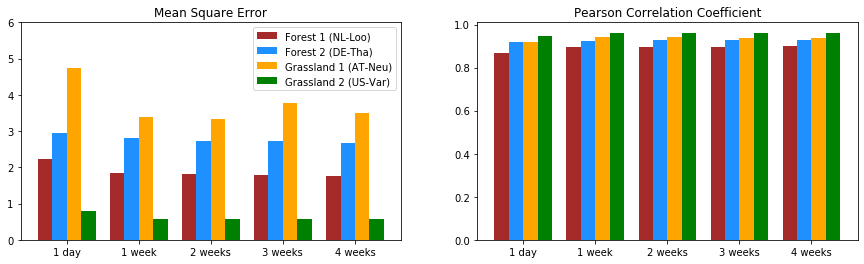

In [248]:
plot_mse_correlation('LSTM_various_input_duration', variants = 5, task = 2, ylim1 = [0, 6])

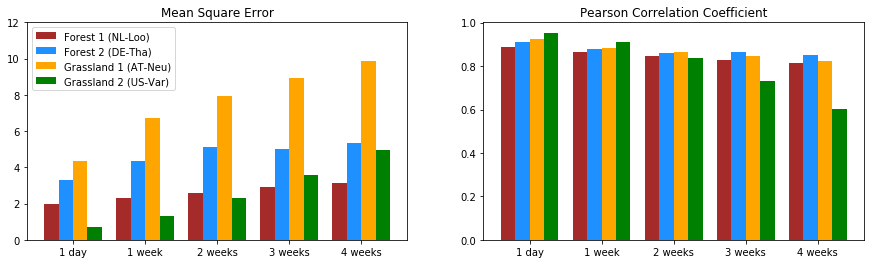

In [249]:
plot_mse_correlation('LSTM_various_prediction_delay', variants = 5, task = 2, ylim1 = [0, 12])